In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors

import tensorflow as tf

#Keras
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense,Dropout
from keras import regularizers
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.metrics import CategoricalAccuracy,Precision,Recall
from keras.optimizers import Adam




In [121]:
def text(path):
    with open(path) as f:
        text=f.read()
    
    return text

def corpus(text,timesteps):
    table=str.maketrans({".":None, "," : None,":" : None,";" : None,"!" : None,'"' :None,"#" :None,"$" :None,"%" :None,"&" :None,"'" :None,'"':None,"(" :None,")" :None,"=" :None,"~" :None,"{" :None,"}" :None,"[" :None,"]" :None,"/":None,"-":None,"_":None,"^":None})
    text=text.lower()
    text=text.translate(table)
    words=text.split()

    corpus=[]
    for i in range(len(words)-timesteps):
        corpus.append(words[i:i+timesteps])

    return corpus

def w2v(corpus,vector_size,window,min_count,sg,w2v_name):
    w2v=Word2Vec(sentences=corpus,vector_size=vector_size,window=window,min_count=min_count,sg=sg)
    w2v.train(corpus,total_examples=len(corpus),epochs=20)
    w2v.save(w2v_name+'_w2v')
    w2v.wv.save_word2vec_format(w2v_name+'_kv',binary=True)

    return

def get_w2v(w2v_kv):
    w2v=KeyedVectors.load_word2vec_format(w2v_kv,binary=True,encoding="UTF-8")
   
    return w2v

def add_w2v(w2v_model_name,corpus):
    
    w2v=Word2Vec.load(w2v_model_name)
    w2v.build_vocab(corpus,update=True)
    w2v.train(corpus,total_examples=len(corpus),epochs=30)
    w2v.save(w2v_model_name)
    w2v.wv.save_word2vec_format(w2v_model_name+'_kv',binary=True)

    return w2v



def get_w2v_word_index(w2v):
   index_word={0:'<pad>'}
   for i in range(len(w2v)):
    index_word[i+1]=w2v.index_to_key[i]
    
   word_index={key : word for word,key in index_word.items()}
    
   return word_index,index_word



def get_emb_mat(w2v, word_index):
    """
    keras.layers.Embeddingのweights引数で指定するための重み行列作成
    model: gensim model
    num_word: modelのvocabularyに登録されている単語数
    emb_dim: 分散表現の次元
    word_index: gensim modelのvocabularyに登録されている単語名をkeyとし、token idをvalueとする辞書 ex) {'word A in gensim model vocab': integer token id} 
    """
    # gensim modelの分散表現を格納するための変数を宣言
    emb_mat = np.zeros((max(list(word_index.values())) + 1, w2v.vector_size), dtype="float32")
   
    # 分散表現を順に行列に格納する
    for word, label in word_index.items():
        try:
            # gensimのvocabularyに登録している文字列をembedding layerに入力するone-hot vectorのインデックスに変換して、該当する重み行列の要素に分散表現を代入
            emb_mat[label] = w2v[word]
        except KeyError:
            pass
    return emb_mat

def pre_get_input_target(corpus,word_index):
    for seq in corpus:
        for i in range(len(seq)):
            try:
                seq[i]=word_index[seq[i]]
            except KeyError:
                seq[i]=0
    pre_input=corpus
        
    pre_tar=[]
    for i in range(len(pre_input)-1):
        pre_tar.append([pre_input[i+1][-1]])
    pre_tar.append([0])

    pre_target=[]
    for i in range(len(pre_tar)):
        if pre_tar[i]==[word_index['el']]:
            pre_target.append([0])
    
        elif pre_tar[i]==[word_index['la']]:
            pre_target.append([1])
    
        elif pre_tar[i]==[word_index['los']]:
            pre_target.append([2])
    
        elif pre_tar[i]==[word_index['las']]:
            pre_target.append([3])
    
        elif pre_tar[i]==[word_index['lo']]:
            pre_target.append([4])
    
        elif pre_tar[i]==[word_index['un']]:
            pre_target.append([5])
    
        elif pre_tar[i]==[word_index['unos']]:
            pre_target.append([6])
    
        elif pre_tar[i]==[word_index['una']]:
            pre_target.append([7])
    
        elif pre_tar[i]==[word_index['unas']]:
            pre_target.append([8])

        elif pre_tar[i]==[word_index['<pad>']]:
            pre_target.append([9])
        
        else:
            pre_target.append([10])
        

    return pre_input,pre_target

def get_input_output(pre_input,pre_target):
    input=[]
    target=[]
    for i in range(len(pre_target)):
        if pre_target[i]==[0] or pre_target[i]==[1] or pre_target[i]==[2] or pre_target[i]==[3] or pre_target[i]==[4] or pre_target[i]==[5] or pre_target[i]==[6] or pre_target[i]==[7] or pre_target[i]==[8] :
            for j in range(5):
                try:
                    input.append(pre_input[i+j])
                    target.append(pre_target[i+j])
                except IndexError:
                    pass
    
    input=np.array(input)
    target=to_categorical(target)

    return input,target

def get_train_test_data(input,target):
    input_train,input_test,target_train,target_test=train_test_split(input,target,test_size=0.2,shuffle=False)
    return input_train,input_test,target_train,target_test
    

In [122]:
text=text('raw_Edited/adventure-novel_after2.txt')
corpus=corpus(text,10)



In [123]:
w2v(corpus,100,2,200,1,'next_word_8')
w2v=get_w2v('next_word_8_kv')

In [124]:
word_index,index_word=get_w2v_word_index(w2v)
emb_mat=get_emb_mat(w2v,word_index)
emb_mat.shape

(14170, 100)

In [125]:
pre_input,pre_target=pre_get_input_target(corpus,word_index)
input,target=get_input_output(pre_input,pre_target)


In [126]:
len(input)

2457275

In [127]:
input_train,input_test,target_train,target_test=get_train_test_data(input,target)

In [128]:
num_words,w2v_size=emb_mat.shape
timestep=10
target_size=11

In [158]:
strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
     model=Sequential()
     model.add(Embedding(input_dim=num_words,output_dim=w2v_size,weights=[emb_mat],mask_zero=True,input_length=timestep))
     #model.add(Dropout(0.25))
     #model.add(LSTM(512,return_sequences=True))
     model.add(Dropout(0.25))
     model.add(LSTM(128,return_sequences=True))
     model.add(Dropout(0.25))
     model.add(LSTM(64))
     model.add(Dropout(0.5))
     model.add(Dense(target_size,activation='softmax',kernel_regularizer=regularizers.l2(0.005)))
     model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=[CategoricalAccuracy(name='acc'),Precision(),Recall()])

     

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [159]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 10, 100)           1417000   
                                                                 
 dropout_27 (Dropout)        (None, 10, 100)           0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 128)           117248    
                                                                 
 dropout_28 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 11)              

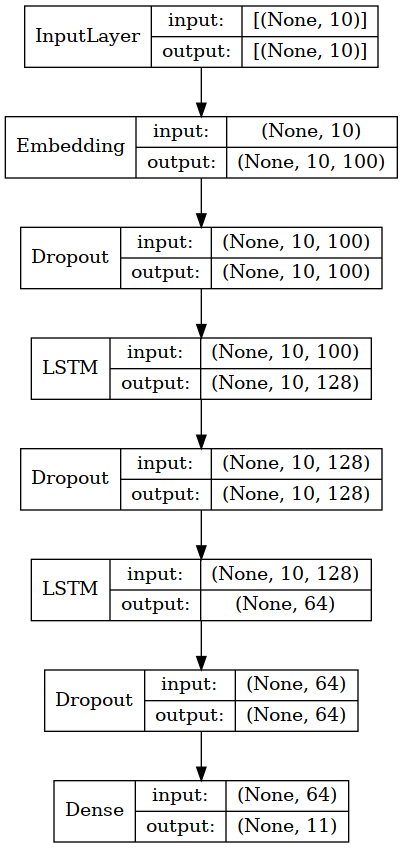

In [160]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [161]:
history=model.fit(input_train,target_train,epochs=30,batch_size=1024,validation_split=0.1,shuffle=False)

Epoch 1/30
1728/1728 [==============================] - 154s 82ms/step - loss: 1.2540 - acc: 0.6856 - precision_11: 0.7593 - recall_11: 0.5955 - val_loss: 1.0202 - val_acc: 0.7139 - val_precision_11: 0.8166 - val_recall_11: 0.6488
Epoch 2/30
1728/1728 [==============================] - 143s 83ms/step - loss: 1.0261 - acc: 0.7143 - precision_11: 0.8206 - recall_11: 0.6325 - val_loss: 0.9694 - val_acc: 0.7168 - val_precision_11: 0.8225 - val_recall_11: 0.6469
Epoch 3/30
1728/1728 [==============================] - 145s 84ms/step - loss: 0.9860 - acc: 0.7190 - precision_11: 0.8237 - recall_11: 0.6354 - val_loss: 0.9479 - val_acc: 0.7205 - val_precision_11: 0.8291 - val_recall_11: 0.6421
Epoch 4/30
1728/1728 [==============================] - 144s 84ms/step - loss: 0.9668 - acc: 0.7213 - precision_11: 0.8255 - recall_11: 0.6370 - val_loss: 0.9366 - val_acc: 0.7222 - val_precision_11: 0.8314 - val_recall_11: 0.6403
Epoch 5/30
1728/1728 [==============================] - 145s 84ms/step - los

In [162]:
model.save('next_word_9.h5')

In [163]:
# 生データの保存
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('next_word_9.csv')

<Figure size 640x480 with 0 Axes>

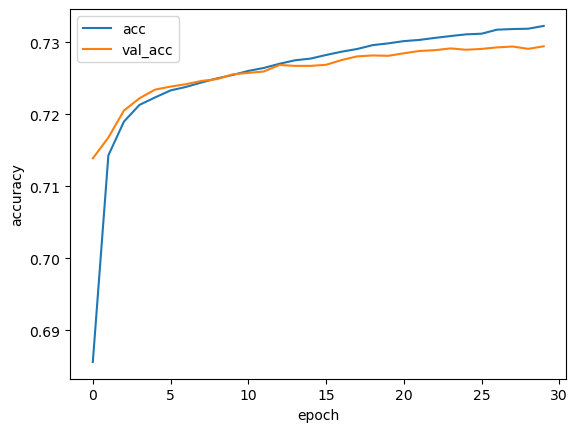

In [164]:
# 可視化
plt.figure()
hist_df[['acc', 'val_acc']].plot()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('next_word_9_acc.png')

<Figure size 640x480 with 0 Axes>

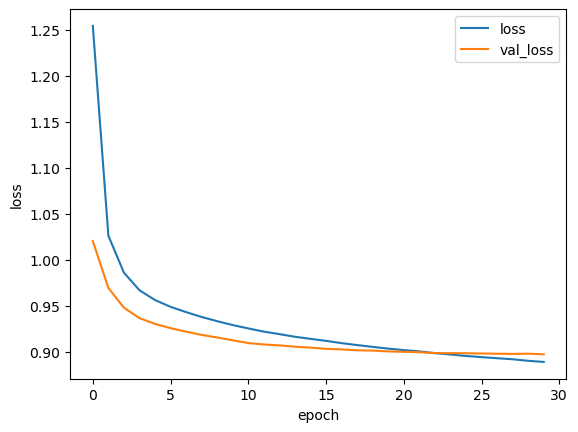

In [165]:
plt.figure()
hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('next_word_9_los.png')

In [166]:
model= tf.keras.models.load_model('next_word_9.h5')

In [167]:
score = model.evaluate(input_test, target_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

15358/15358 [==============================] - 195s 13ms/step - loss: 0.9631 - acc: 0.7112 - precision_11: 0.8056 - recall_11: 0.6420

Test loss: 0.9631243348121643
Test accuracy: 0.7112411260604858
Test precision: 0.8056190013885498
Test recall: 0.6420445442199707


In [169]:
2*score[2]*score[3]/(score[2]+score[3])

0.7145904670052846

In [168]:
model.save('next_word_8.h5')

18230